# Digital Signal and Image Management
###### Assignment 1


> **Cognome**: Sofia    **Nome**: Davoli                                  \\
> **Matricola**: 813479                                                     \\
                                   \\


## Libraries

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

#-- Classification Tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

#-- File Management
from google.colab import drive
import tarfile
from shutil import copyfile

#-- Advanced Audio Features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

## Files Reading

In [ ]:
drive.mount("/content/gdrive")

In [ ]:
#@title Copia del File `recording.tar` {display-mode: "form"}

copyfile("gdrive/My Drive/dsim_material_E02/recordings.tar", "recordings.tar")

'recordings.tar'

In [ ]:
tar = tarfile.open("recordings.tar")
tar.extractall()  #extract all files
tar.close()

## Functions definition

- load_data functions take in input a parameter to specify which features to extract when loading data, this will be used when creating training and test sets.

- 6 different features extaction functions (aavg, sdev, duration, energy, zcr and mfcc)

- 2 combo function to extract features all in one time ( this 2 functions differs for 1 features extraction method: ZCR)

In [ ]:
#-- Placecholder per estrarre le Feature
def identity(input):
    return input

# Data loader
def load_data(feature_extractor = identity, normalize = False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            #-- Caricare i File e Calcolo delle Esplicative
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            #-- Classi
            label = f.split('_')[0]
            labels.append(label)

    #-- X: Variabili Esplicative, y: Risposta
    X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                        test_size = 0.1,
                                                        random_state = 1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis = 0)
        X_train_std = X_train.std(axis = 0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [ ]:
def crop(input, size = 100):
  output = input[0 : min(size, input.shape[0])]
  output = np.concatenate((output, np.zeros(size - output.shape[0])))
  return output

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def sdev(input):
    return np.std(input, keepdims = True)

def aavg(input):
    return np.mean(np.abs(input), keepdims = True)

def duration(input):
    return input.shape

 ***Z***ero ***C***rossing ***R***ate (**ZCR**): The zero-crossing rate of an audio frame (or more in general of a signal) is the rate of sign-changes of the signal during the frame. In other words, it is the number of times the signal changes value, from positive to negative and vice versa, divided by the length of the frame.


Function implemented take as input a signal and return ZCR value: 
 - np.signbit function return an array of TRUE - FALSE (TRUE if number is positive, FALSE if negative)
 - np.where(np.diff()) this joined numpy functions allows to get the positions in the array where there are changes between TRUE - FALSE (previous value is positive and next is negative and viceversa). this return a list whith an array inside which have to be extracted using [0] command.
 - finally the shape of the array is extracted. this shape represent the number of changing of sign in the signal.
 - since an array is needed to be returned, np.array is applied to the first value of the shape (number of sign changes) and since a RATE is needed the ZERO CROSSING times value is divided by the lenght (shape[0]) of the signal.

In [ ]:
def zcr(input):
  x = np.where(np.diff(np.signbit(input)))[0].shape  
  return np.array([x[0]])/signal.shape[0]


In [ ]:
def mfcc(input, rate=8000, min_len=40, sampling=1):
    
    signal = input[::sampling] #-- Valori Campionati
    
    mfcc = librosa.feature.mfcc(signal*1.0, sr = int(rate/sampling)) #-- Calcolo Coefficienti MFCC
    
    pad_width = min_len - mfcc.shape[1] #-- Aggiunta 0 necessari per Lunghezza Equa
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode = 'constant')

    #-- Flatten into monodimensional vector for the SVM
    mfcc = mfcc.flatten()
    return mfcc

In [ ]:
def combo(input):
    return np.concatenate((aavg(input), sdev(input),
                           duration(input), energy(input)))

def combo_con_zcr(input):
    return np.concatenate((aavg(input), sdev(input),
                           duration(input), energy(input),
                           zcr(input)))

## Model Training
SVM model is used to train and test model whithout  ZCR feature. Results of this models will be compared with the same model's result obtained including ZCR feature, and with the same model trained using mfcc features

### SVM without ZCR


In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo,
                                             normalize = True)

#-- Dimensionalità delle Variabili Esplicative
X_train[0].shape

(4,)

In [ ]:
#-- Parametri da Testare nella Cross-Validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

#-- Inizializzatore della Support Vector Machine
clf = GridSearchCV(SVC(kernel = 'rbf',
                       class_weight = 'balanced'),
                   param_grid, cv = 2)

#-- Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))
print("\n")
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Training completed in 3.579s


Best parameters combination:
 C: 1000.0
 gamma: 0.5


### SVM with ZCR features

In [ ]:
X_train_zcr, X_test_zcr, y_train_zcr, y_test_zcr = load_data(feature_extractor = combo_con_zcr,
                                                             normalize = True)

#-- Dimensionalità delle Variabili Esplicative
X_train_zcr[0].shape

(5,)

In [ ]:
#-- Parametri da Testare nella Cross-Validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

#-- Inizializzatore della Support Vector Machine
clf_zcr = GridSearchCV(SVC(kernel = 'rbf',
                       class_weight = 'balanced'),
                   param_grid, cv = 2)

#-- Training
t0 = time()
clf_zcr = clf_zcr.fit(X_train_zcr, y_train_zcr)
print('Training completed in %0.3fs' % (time() - t0))
print("\n")
print('Best parameters combination:')
print(' C: '+str(clf_zcr.best_estimator_.C))
print(' gamma: '+str(clf_zcr.best_estimator_.gamma))

Training completed in 2.318s


Best parameters combination:
 C: 500.0
 gamma: 0.1


## Test

### SVM without ZCR

In [ ]:
y_pred = clf.predict(X_test)         #-- Test

print(classification_report(y_test,
                            y_pred)) #-- Report della Classificazione
print(confusion_matrix(y_test,
                       y_pred))      #-- Matrice di Confusione

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.33      0.40      0.36        10
           2       0.28      0.33      0.30        15
           3       0.53      0.42      0.47        19
           4       0.36      0.45      0.40        11
           5       0.44      0.29      0.35        14
           6       0.79      0.79      0.79        14
           7       0.80      0.42      0.55        19
           8       0.35      0.41      0.38        17
           9       0.32      0.43      0.36        14

    accuracy                           0.46       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150

[[11  0  0  0  0  0  0  0  0  6]
 [ 0  4  2  2  0  1  0  0  1  0]
 [ 2  1  5  3  0  0  0  0  2  2]
 [ 0  3  7  8  0  0  0  0  0  1]
 [ 1  1  1  1  5  2  0  0  0  0]
 [ 1  0  0  1  4  4  1  0  2  1]
 [ 0  0  0  0  0  0 11  1  2  0]
 [ 0  0  0

### SVM con ZCR

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.53      0.90      0.67        10
           2       0.64      0.60      0.62        15
           3       0.75      0.63      0.69        19
           4       0.47      0.64      0.54        11
           5       0.53      0.64      0.58        14
           6       0.87      0.93      0.90        14
           7       0.89      0.42      0.57        19
           8       0.56      0.59      0.57        17
           9       0.82      0.64      0.72        14

    accuracy                           0.67       150
   macro avg       0.68      0.68      0.67       150
weighted avg       0.70      0.67      0.67       150

[[14  0  1  0  0  0  0  0  0  2]
 [ 0  9  0  0  1  0  0  0  0  0]
 [ 0  0  9  2  0  1  1  0  2  0]
 [ 1  1  1 12  1  2  1  0  0  0]
 [ 0  2  1  1  7  0  0  0  0  0]
 [ 0  1  1  0  1  9  0  1  1  0]
 [ 0  0  0  0  0  0 13  0  1  0]
 [ 1  1  0

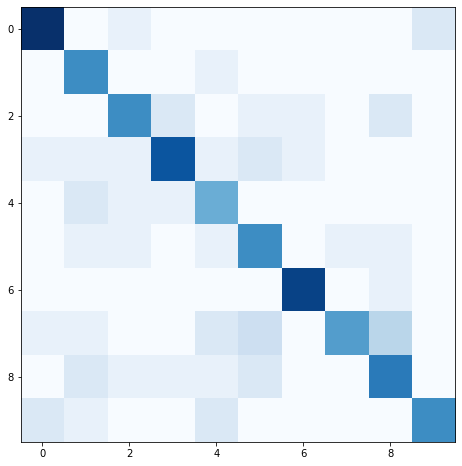

In [ ]:
y_pred_zcr = clf_zcr.predict(X_test_zcr) #-- Test

print(classification_report(y_test_zcr,
                            y_pred_zcr)) #-- Report della Classificazione
print(confusion_matrix(y_test_zcr,
                       y_pred_zcr))      #-- Matrice di Confusione

plt.figure(figsize = (12, 8))
plt.imshow(confusion_matrix(y_test_zcr,
                            y_pred_zcr),
           cmap = plt.cm.Blues)

### SVM with mfcc features 

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2033
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1963
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2007
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1976
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1987
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1886
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa

Training completed in 309.161s


Best parameters combination:
 C: 100.0
 gamma: 0.005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      0.93      0.96        14
           6       0.82      1.00      0.90        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       1.00      0.93      0.96        14

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

[[17  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0 

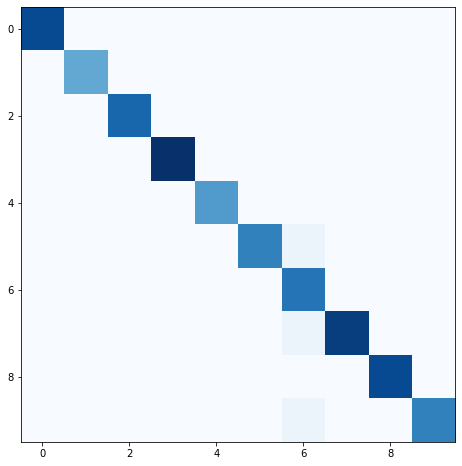

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = mfcc,
                                             normalize = True)
len(X_train)
X_train[0].shape

param_grid = {'C': [1e2, 5e2, 1e3],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

clf = GridSearchCV(SVC(kernel = 'rbf',
                       class_weight = 'balanced'),
                    param_grid,
                    cv = 2)

clf = clf.fit(X_train,
            y_train)

clf.best_estimator_.C
clf.best_estimator_.gamma


print('Training completed in %0.3fs' % (time() - t0))
print("\n")
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

y_pred = clf.predict(X_test)
print(classification_report(y_test,
                            y_pred))

print(confusion_matrix(y_test,
                       y_pred))

plt.figure(figsize = (12, 8))
plt.imshow(confusion_matrix(y_test,
                            y_pred),
           cmap = plt.cm.Blues)

### Conclusions


ZCR improve results of classification, in fact accuracy change from 0.46 (svm without zcr) to 0.67. This means that signal can be distinghuished by the number of zero-crossing. 
Results using mfcc features are the best obtained in term of accuracy (0.97) but this methodss result in being more time consuming than the previous trained. 